<a href="https://colab.research.google.com/github/jong9810/TensorFlow-2.0/blob/main/12_1_GTSRB_Data_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GTSRB 데이터를 활용한 예제 : GTSRB Project
- GTSRB(German Traffic Recognition Benchmark)
- : 독일 신경 정보학 연구원들이 교통 표지판을 예측하기 위해 만든 데이터이다. - 평균적으로 32 * 32 크기를 가지는 color 이미지이고, 43개의 교통 표지판과 관련된 약 4만 개의 이미지를 포함한다.

### 모델 개요
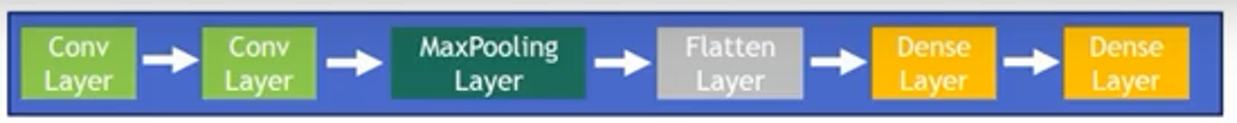

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import cv2
import glob

tf.__version__

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# # 파일 다운로드
# # !wget 링크 주소, 파일이름 : 링크 주소에 있는 파일을 현재 디렉토리에 다운로드 받음
# !wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_images

In [ ]:
# # 압축 파일을 다루는 모듈
# import zipfile

# # .extractall()함수 : 지정한 파일에 대해 모두 압축을 풀어줌
# with zipfile.ZipFile('/content/GTSRB_Final_Training_Images.zip', 'r') as target_file:
#     target_file.extractall()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# ROOT_DIR, DATA_ROOT_DIR 변수를 선언하여 코드를 작성하는 이유
# : 나중에 다른 디렉토리에서 데이터를 가져올 때, ROOT_DIR과 DATA_ROOT_DIR만 변경하면 데이터를 로드할 수 있다. (호환성이 높아짐)
import os

ROOT_DIR = '/content/gdrive/My Drive/Colab Notebooks/dataset/'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'GTSRB/Final_Training/Images/')
# print(DATA_ROOT_DIR)

In [ ]:
# 압축 파일을 다루는 모듈
import zipfile

# 압축파일.extractall('경로')함수 : 지정한 '압축파일'에 대해 모두 압축을 풀어서 '경로'에 저장
with zipfile.ZipFile(ROOT_DIR+'GTSRB_Final_Training_Images.zip', 'r') as target_file:
    target_file.extractall(ROOT_DIR)

In [ ]:
# 데이터 전처리 (train data, test data 생성, 정규화 등)
import os
import cv2
import glob

image_list = []
label_list = []

# os.listdir('경로') : 경로 안에 있는 폴더(파일, 디렉토리?)의 이름을 모두 읽어와서 리스트 형태로 만들어줌
image_label_list = os.listdir(DATA_ROOT_DIR) # <- 정답 리스트 image_label_list = ['00000', '00001', ..., '00042']

for label_name in image_label_list:
    # 이미지 파일 읽어오기
    # glob.glob('파일 이름') : 파일 이름에 해당하는 파일을 반환해줌
    file_path = os.path.join(DATA_ROOT_DIR, label_name)
    img_file_list = glob.glob(file_path+'/*.ppm')
    # 각각의 정답 디렉토리에 있는 이미지 파일, 즉 ppm 파일을 읽어서 리스트에 저장

    for img_file in img_file_list:
        try:
            # 정답 디렉토리에 있는 이미지를 OpenCV를 이용해서 읽어들임
            src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
            src_img = cv2.resize(src_img, dsize=(32,32))
            src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

            # 이미지와 정답을 리스트에 추가함.
            # 정답에 해당하는 이미지를 순서에 맞게 리스트에 추가함
            image_list.append(src_img)
            label_list.append(float(label_name))

        except Exception as err:
            print(str(err), img_file)
            continue

In [ ]:
x_train = np.array(image_list).astype('float32')
y_train = np.array(label_list).astype('float32')
# print(x_train.shape, y_train.shape)

In [ ]:
# x_train, y_train을 직접 shuffle하면 정답 데이터와 이미지 데이터의 순서가 맞지 않기 때문에 임의로 s 라는 배열을 정의하여 랜덤하게 재배열시켜줌
s = np.arange(len(x_train)) #[0, 1, 2, ..., 39207, 39208]
np.random.shuffle(s) # s 리스트의 index 랜덤으로 재배열

# 랜덤으로 재배열된 s 리스트를 이용해 x_train, y_train 순서를 재배열
x_train = x_train[s] 
y_train = y_train[s]

In [ ]:
SPLIT_RATIO = 0.2 
SPLIT_NUMS = int(len(x_train) * SPLIT_RATIO)

x_test = x_train[0:SPLIT_NUMS]
y_test = y_train[0:SPLIT_NUMS]

x_train = x_train[SPLIT_NUMS:]
y_train = y_train[SPLIT_NUMS:]

# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)

In [ ]:
# x_train, x_test 정규화
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [ ]:
# 모델 구축
n_classes = len(os.listdir(DATA_ROOT_DIR)) # 정답 개수

model = Sequential()

model.add(Conv2D(input_shape=x_train[0].shape, kernel_size=(3,3), filters=32, activation='relu'))
model.add(Conv2D(kernel_size=(3,3), filters=64, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# monitor='val_loss', patience=5 : 개선 되지 않은 eopch 이후에 5번 epochs 동안 'val_loss'가 개선되지 않으면 계산을 멈춤
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

hist = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[earlystopping])

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.legend(loc='best')
plt.show()

In [ ]:
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')

plt.title('Accuarcy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
pred = model.predict(x_train[:25])
pred

In [ ]:
# y_train

In [ ]:
plt.figure(figsize=(6,6))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i])
    plt.axis('off')
    plt.title('label : ' + str(int(y_train[i])) + '\npred : ' + str(np.argmax(pred[i])))
plt.show()